```
!/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/bin/kaggle datasets download -d nphantawee/pump-sensor-data

ls -l

!unzip pump-sensor-data.zip
```

In [1]:
import sys

In [2]:
sys.path.append('../../')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
import torch
import pytorch_lightning as pl

In [6]:
import logging
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [7]:
import warnings

# Data

In [8]:
df_data = pd.read_csv('sensor.csv', index_col=0)

In [9]:
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])

In [10]:
df_data = df_data.set_index('timestamp').sort_index()

In [11]:
y_data = df_data['machine_status']

In [12]:
x_data = df_data.drop(columns='machine_status')

In [13]:
x_data.isna().mean().sort_values()

sensor_23    0.000073
sensor_28    0.000073
sensor_27    0.000073
sensor_34    0.000073
sensor_24    0.000073
sensor_35    0.000073
sensor_36    0.000073
sensor_21    0.000073
sensor_20    0.000073
sensor_19    0.000073
sensor_37    0.000073
sensor_33    0.000073
sensor_31    0.000073
sensor_13    0.000086
sensor_11    0.000086
sensor_02    0.000086
sensor_10    0.000086
sensor_03    0.000086
sensor_12    0.000086
sensor_04    0.000086
sensor_05    0.000086
sensor_26    0.000091
sensor_14    0.000095
sensor_45    0.000123
sensor_43    0.000123
sensor_42    0.000123
sensor_41    0.000123
sensor_38    0.000123
sensor_39    0.000123
sensor_44    0.000123
sensor_40    0.000123
sensor_47    0.000123
sensor_48    0.000123
sensor_46    0.000123
sensor_49    0.000123
sensor_16    0.000141
sensor_25    0.000163
sensor_22    0.000186
sensor_18    0.000209
sensor_17    0.000209
sensor_32    0.000309
sensor_29    0.000327
sensor_30    0.001185
sensor_01    0.001675
sensor_09    0.020856
sensor_06 

In [14]:
y_data.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

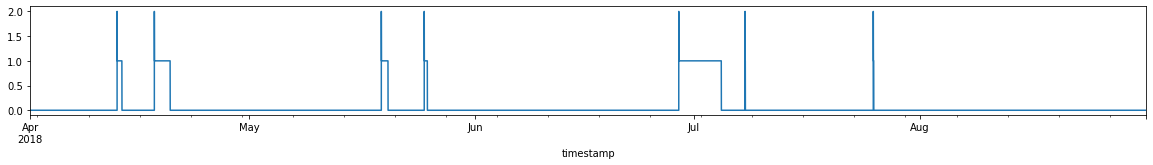

In [15]:
y_data.map({'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}).plot(figsize=(20, 2))
plt.show()

In [16]:
x_data = x_data.fillna(method='ffill').drop(columns='sensor_15')

In [17]:
x_data.index.max() - x_data.index.min()

Timedelta('152 days 23:59:00')

In [18]:
len(x_data), len(x_data) / 153

(220320, 1440.0)

In [19]:
print('Mean recovering time {:1f}'.format(y_data.eq('RECOVERING').sum() / y_data.eq('BROKEN').sum()))

Mean recovering time 2068.142857


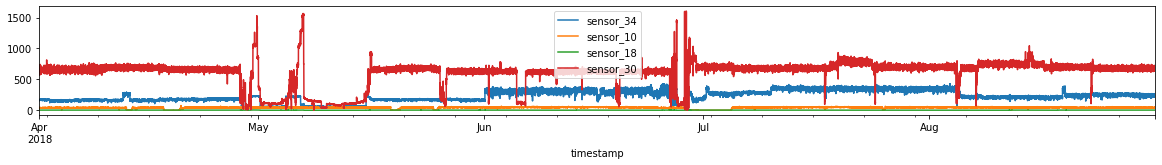

In [20]:
x_data.iloc[:, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

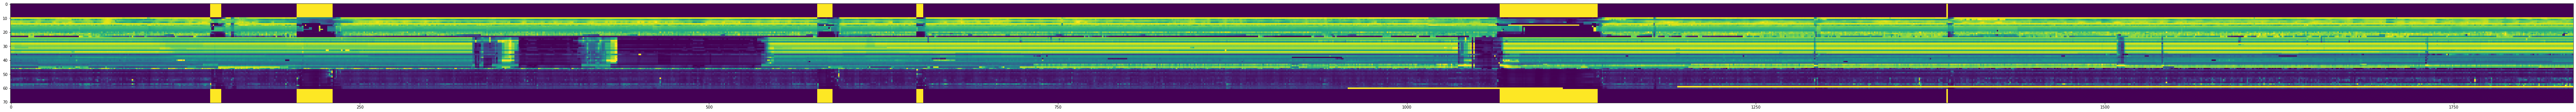

In [21]:
_, axs = plt.subplots(1, 1, figsize=(120, 3 * 5))

t = x_data.values[::120, :]
t = t - t.min(axis=0, keepdims=True)
t = t / t.max(axis=0, keepdims=True)
tx = t

axs.imshow(np.concatenate([
    (y_data != 'NORMAL').values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::120],
    tx.T,
    (y_data != 'NORMAL').values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::120],
], axis=0))
plt.show()

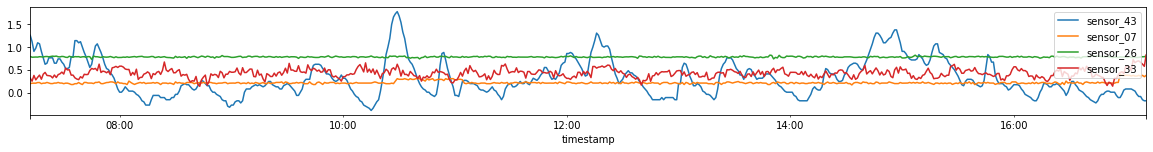

In [22]:
p = np.random.randint(0, 220320 - 120 * 5)
((x_data - x_data.mean()) / x_data.std()).clip(-5, 5) \
    .iloc[p : p + 120 * 5, np.random.choice(x_data.shape[1], 4, replace=False)].plot(figsize=(20, 2))
plt.show()

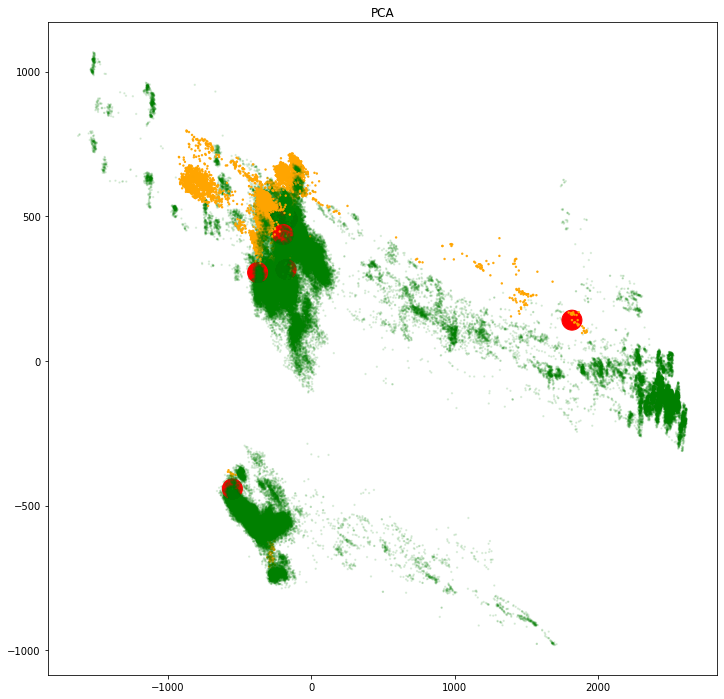

In [23]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(x_data.values)

plt.figure(figsize=(12, 12))
plt.scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({'NORMAL': 'green', 'RECOVERING': 'orange', 'BROKEN': 'red'}).values,
    s=y_data.map({'NORMAL': 2, 'RECOVERING': 2, 'BROKEN': 400}).values,
    alpha=y_data.map({'NORMAL': 0.1, 'RECOVERING': 0.9, 'BROKEN': 1.0}).values,
)
plt.title('PCA')
plt.show()

# Feature construction approach

In [24]:
predict_size = 10

In [25]:
y_data = y_data.map({'NORMAL': 0}).fillna(1)

In [26]:
y_target = y_data.rolling(window=predict_size, min_periods=1).max().shift(-predict_size)

# X features

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [28]:
def evaluate_features(X_raw, history_size, model):
    train_end = X_raw.shape[0] // 2
    
    _rolling = X_raw.rolling(window=history_size, min_periods=1)
    X = pd.concat([
        _rolling.mean().rename(columns={c: f'{c}_mean' for c in x_data.columns}),
        _rolling.min().rename(columns={c: f'{c}_min' for c in x_data.columns}),
        _rolling.max().rename(columns={c: f'{c}_max' for c in x_data.columns}),
        _rolling.median().rename(columns={c: f'{c}_median' for c in x_data.columns}),
        _rolling.std().rename(columns={c: f'{c}_std' for c in x_data.columns}).fillna(method='bfill'),
    ], axis=1)
    print(f'X shape after feature construction: {X.shape}')
    
#   model = RandomForestClassifier(random_state=42, n_jobs=16)
    model.fit(
        X[:train_end],
        y_target[:train_end],
    )

    y_predict = model.predict_proba(X)[:, 1]
    
    print(confusion_matrix(
        y_target.values[:train_end], 
        y_predict[:train_end] > 0.5,
    ), 'train')

    print(confusion_matrix(
        y_target.values[train_end:-predict_size], 
        y_predict[train_end:-predict_size] > 0.5,
    ), 'valid')

    print(confusion_matrix(
        y_target.values[:train_end][(y_data == 0)[:train_end]], 
        y_predict[:train_end][(y_data == 0)[:train_end]] > 0.5,
    ), 'train before')

    print(confusion_matrix(
        y_target.values[train_end:-predict_size][(y_data == 0)[train_end:-predict_size]], 
        y_predict[train_end:-predict_size][(y_data == 0)[train_end:-predict_size]] > 0.5,
    ), 'valid before')
    
    
    plt.figure(figsize=(12, 2))
    plt.hist(y_predict[:train_end], bins=50, alpha=0.5)
    plt.hist(y_predict[train_end:], bins=50, alpha=0.5)
    plt.yscale('log')
    plt.show()

    
    plt.figure(figsize=(18, 2))
    plt.plot(y_target.values)
    plt.plot(y_data.values)
    plt.plot(0.1 + y_predict)
    plt.axvline(train_end, color='red')
    plt.show()

    broken_pos = np.where((np.diff(y_data) == 1) | (np.diff((y_predict > 0.5).astype(int)) == 1))[0]
    
    _b = broken_pos
    broken_pos = []
    last_seen = 0
    for i in _b:
        if i < last_seen:
            continue
        last_seen = i + 40
        broken_pos.append(i)
    
    if len(broken_pos) > 20:
        broken_pos = broken_pos[:20]
        
    _, axs = plt.subplots(len(broken_pos), 1, figsize=(16, 1.5 * len(broken_pos)))
    for i, ax in zip(broken_pos, axs):
        ax.plot(y_target.values, label='target')
        ax.plot(y_data.values, label='realtime')
        ax.plot(0.1 + y_predict, label='predict')
        ax.axvline(train_end, color='red')
        ax.set_xlim(i - 400, i + 50)
        ax.legend()
    plt.show()

X shape after feature construction: (220320, 255)
[[104149      0]
 [     0   6011]] train
[[101284    330]
 [    40   8496]] valid
[[104145      0]
 [     0     40]] train before
[[101283    328]
 [    13     17]] valid before


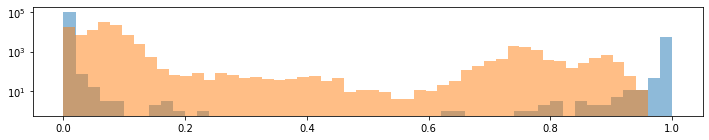

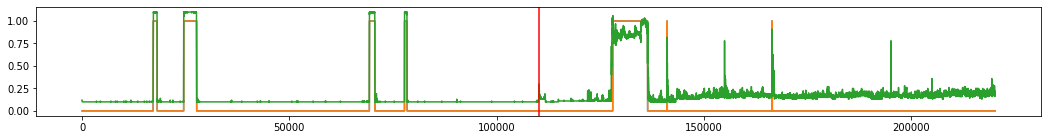

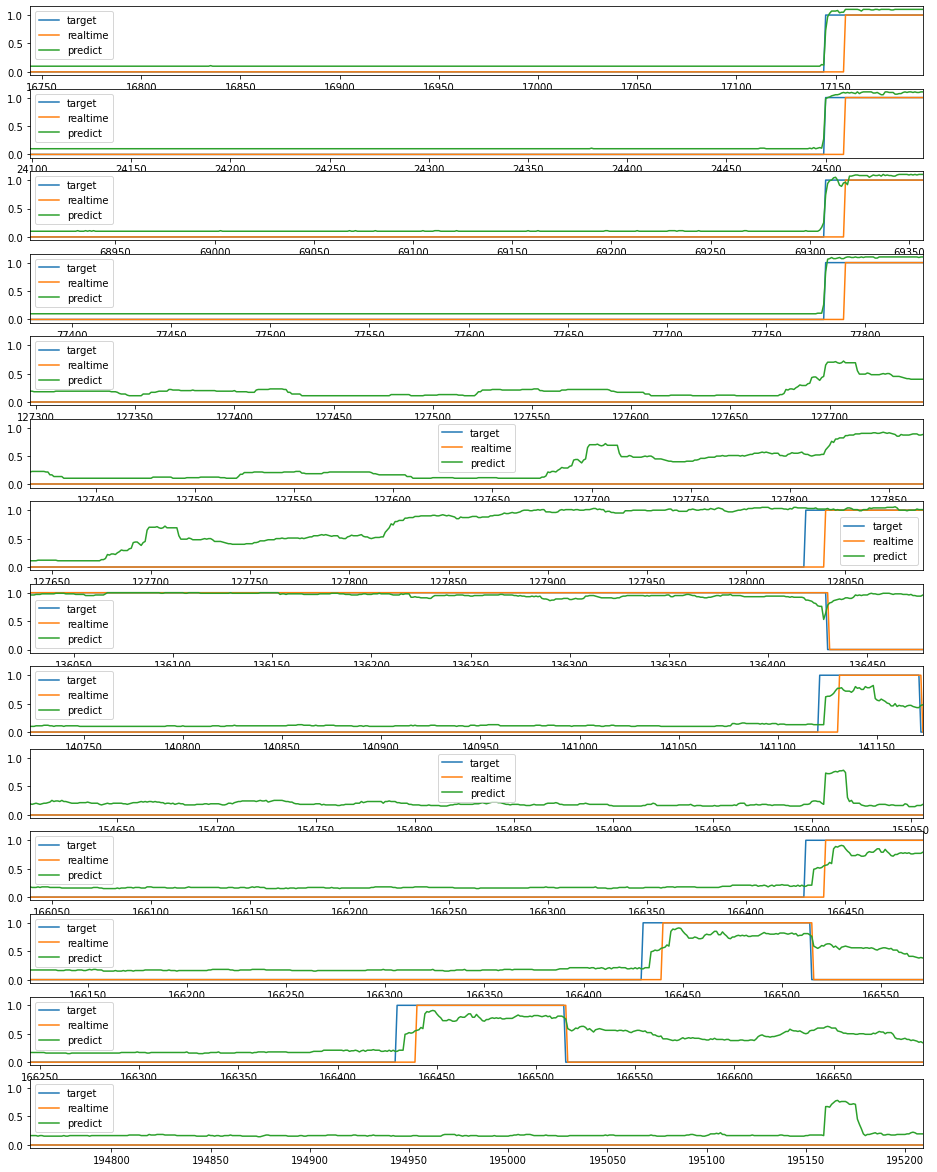

In [29]:
evaluate_features(x_data, history_size=10, model=RandomForestClassifier(random_state=42, n_jobs=16))

# Make Z and C with predictive coding

In [30]:
# !rm -r lightning_logs/

In [31]:
import dltranz.lightning_modules.stream_encoder as se

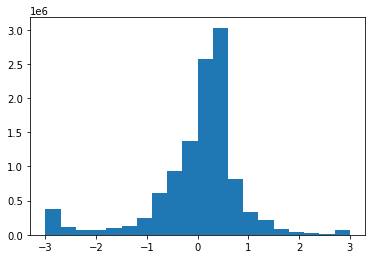

In [40]:
plt.hist(((x_data - x_data.mean()) / x_data.std()).values.flatten().clip(-3, 3), bins=20)
plt.show()

In [33]:
predict_w = 0.65 ** np.arange(0, 4)
predict_w = predict_w / predict_w.sum()
predict_w.round(3)

array([0.426, 0.277, 0.18 , 0.117])

In [34]:
stream_encoder = se.StreamEncoder(
    encoder_x2z=torch.nn.Sequential(
        se.TBatchNorm(x_data.shape[1]),
        se.ClipRange((-3, 3)),
        se.TSwapChannels(),
        torch.nn.Conv1d(
            in_channels=x_data.shape[1], out_channels=16,
            kernel_size=10, stride=10,
        ),
        se.TSwapChannels(),
    ),
    history_size=30, predict_range=[0, 1, -2, -1], predict_w=predict_w,
    z_channels=16, c_channels=32,
    lr=0.00001, weight_decay=0.0001,
    step_size=5, gamma=0.9,
    cpc_w=0.1, cov_z_w=1.0, var_z_w=1.0, cov_c_w=1.0, var_c_w=1.0, cpc_neg_w=0.0,
)
compress_factor = 10

In [35]:
l3dt = se.Loader3DTensor(stream_encoder)
dl_train = l3dt.get_train_dataloader(
    torch.from_numpy(x_data.values[:x_data.shape[0] // 2]).unsqueeze(0).float(), 128, 12, compress_factor)
dl_valid = l3dt.get_valid_dataloader(
    torch.from_numpy(x_data.values[x_data.shape[0] // 2:]).unsqueeze(0).float(), 512, 1)

In [36]:
print(len(dl_train), len(dl_valid))
print(next(iter(dl_train))[0].shape, next(iter(dl_valid))[0].shape)

859 1
torch.Size([128, 320, 51]) torch.Size([1, 110160, 51])


In [37]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=2,
    log_every_n_steps=10,
    progress_bar_refresh_rate=50, weights_summary=None,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        name='vic_test',
        default_hp_metric=False,
    )
)

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
trainer.logged_metrics['hp/cpc_pow']

tensor(-1.6916)

In [44]:
def train_model(min_epochs, max_epochs, logger_name, config):
    stream_encoder = se.StreamEncoder(**config)
    compress_factor = 10

    l3dt = se.Loader3DTensor(stream_encoder)
    dl_train = l3dt.get_train_dataloader(
        torch.from_numpy(x_data.values[:x_data.shape[0] // 2]).unsqueeze(0).float(), 128, 12, compress_factor)
    dl_valid = l3dt.get_valid_dataloader(
        torch.from_numpy(x_data.values[x_data.shape[0] // 2:]).unsqueeze(0).float(), 512, 1)    
    
    trainer = pl.Trainer(
        gpus=[3],
        max_epochs=max_epochs,
        min_epochs=min_epochs,
        log_every_n_steps=10,
        progress_bar_refresh_rate=0, weights_summary=None,
        logger=pl.loggers.TensorBoardLogger(
            save_dir='lightning_logs/',
            name=logger_name,
            default_hp_metric=False,
        ),
        callbacks=[
            pl.callbacks.EarlyStopping(monitor='hp/cpc_pow', mode='max'),
        ],
    )
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)
    return trainer.logged_metrics['hp/cpc_pow']

In [45]:
def get_default_params_vic():
    return dict(
        encoder_x2z=torch.nn.Sequential(
            se.TBatchNorm(x_data.shape[1]),
            se.ClipRange((-3, 3)),
            se.TSwapChannels(),
            torch.nn.Conv1d(
                in_channels=x_data.shape[1], out_channels=16,
                kernel_size=10, stride=10,
            ),
            se.TSwapChannels(),
        ),
        history_size=30, predict_range=[0, 1, -2, -1], predict_w=predict_w,
        z_channels=16, c_channels=32,
        lr=0.00001, weight_decay=0.0001,
        step_size=5, gamma=0.9,
        cpc_w=0.1, cov_z_w=1.0, var_z_w=1.0, cov_c_w=1.0, var_c_w=1.0, cpc_neg_w=0.0,
    )

In [48]:
pbounds = dict(
    lr=(1e-6, 1e-1),
    cpc_w=(0.0001, 10.0),
    cov_z_w=(0.0001, 10.0),
    var_z_w=(0.0001, 10.0),
    cov_c_w=(0.0001, 10.0),
    var_c_w=(0.0001, 10.0),
)

In [51]:
def sample_log_uniform(l, h):
    l, h = np.log([l, h])
    return np.exp(np.random.rand(1)[0] * (h - l) + l)

In [74]:
# random search
for i in range(15):
    print(f'[{i:03d}] - start', end='')
    p = get_default_params_vic()
    for k, (l, h) in pbounds.items():
        p[k] = sample_log_uniform(l, h)
    
    train_model(min_epochs=5, max_epochs=50, logger_name='vic', config=p)
    print(f' - done')

[000] - stats - done
[001] - stats - done
[002] - stats - done
[003] - stats - done
[004] - stats - done


In [54]:
import dltranz.tb_interface as tb

In [76]:
df_results = pd.concat([
    tb.get_last_scalars('lightning_logs/vic/')['value'],
    tb.get_hparams('lightning_logs/vic/'),
], axis=1)

In [77]:
p_keys = list(pbounds.keys())

In [78]:
df_results[p_keys + ['hp/cpc_pow']].sort_values('hp/cpc_pow', ascending=False)

,lr,cpc_w,cov_z_w,var_z_w,cov_c_w,var_c_w,hp/cpc_pow
version_12,0.002647,0.121239,0.001224,0.028165,3.203741,0.016627,2.517847
version_14,0.000546,0.203965,0.704069,0.046054,0.000157,0.077588,1.740534
version_13,0.000692,0.027182,0.207775,1.772739,0.018360,9.373873,1.508071
version_3,0.000767,0.019784,0.000370,5.429354,0.002775,0.001479,1.243277
version_2,0.000220,0.533388,0.006625,0.000403,0.001129,0.040640,0.918501
version_6,0.000507,0.000694,0.000676,0.032509,0.000797,0.000276,0.259694
version_4,0.083922,0.000425,0.038217,0.000188,0.000222,0.250649,0.030235
version_11,0.000006,9.068906,0.173659,0.017744,0.008652,0.014032,-0.361403
version_9,0.000047,0.047975,0.454209,0.005630,0.023288,0.001383,-0.568898
version_7,0.003249,0.002147,0.866035,0.000512,0.855694,8.295539,-0.934769


In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels as K

In [70]:
df_results['hp/cpc_pow'].sort_values(ascending=False).iloc[:5].std()

0.7197893871197362

In [117]:
df_results = pd.concat([
    tb.get_last_scalars('lightning_logs/vic/')['value'],
    tb.get_hparams('lightning_logs/vic/'),
], axis=1)

t_model = GaussianProcessRegressor(kernel=K.WhiteKernel(0.1) + K.RBF(1.0))
t_model.fit(np.log(df_results[p_keys].values), df_results['hp/cpc_pow'].values.clip(-2, None))

df_results['pred'], df_results['std'] = t_model.predict(np.log(df_results[p_keys].values), return_std=True)
df_results['pred_l'] = df_results['pred'] - df_results['std']
df_results['pred_h'] = df_results['pred'] + df_results['std']

df_results[p_keys + ['hp/cpc_pow', 'pred', 'std', 'pred_l', 'pred_h']].sort_values('pred', ascending=False)

,lr,cpc_w,cov_z_w,var_z_w,cov_c_w,var_c_w,hp/cpc_pow,pred,std,pred_l,pred_h
version_12,0.002647,0.121239,0.001224,0.028165,3.203741,0.016627,2.517847,1.069608,1.388949,-0.319341,2.458557
version_14,0.000546,0.203965,0.704069,0.046054,0.000157,0.077588,1.740534,0.739397,1.388949,-0.649552,2.128347
version_13,0.000692,0.027182,0.207775,1.772739,0.018360,9.373873,1.508071,0.640645,1.388949,-0.748304,2.029594
version_3,0.000767,0.019784,0.000370,5.429354,0.002775,0.001479,1.243277,0.528157,1.388949,-0.860792,1.917106
version_2,0.000220,0.533388,0.006625,0.000403,0.001129,0.040640,0.918501,0.390189,1.388949,-0.998760,1.779138
version_6,0.000507,0.000694,0.000676,0.032509,0.000797,0.000276,0.259694,0.110321,1.388949,-1.278628,1.499270
version_4,0.083922,0.000425,0.038217,0.000188,0.000222,0.250649,0.030235,0.012844,1.388949,-1.376105,1.401793
version_11,0.000006,9.068906,0.173659,0.017744,0.008652,0.014032,-0.361403,-0.153528,1.388949,-1.542477,1.235421
version_9,0.000047,0.047975,0.454209,0.005630,0.023288,0.001383,-0.568898,-0.241674,1.388949,-1.630623,1.147275
version_7,0.003249,0.002147,0.866035,0.000512,0.855694,8.295539,-0.934769,-0.397100,1.388949,-1.786049,0.991849


In [102]:
from itertools import product

In [171]:
def get_next_candidate(best_by='pred_l'):
    df_results = pd.concat([
        tb.get_last_scalars('lightning_logs/vic/')['value'],
        tb.get_hparams('lightning_logs/vic/'),
    ], axis=1)

    t_model = GaussianProcessRegressor(kernel=K.WhiteKernel(0.0001) + K.RBF(1.0))
    t_model.fit(np.log(df_results[p_keys].values), df_results['hp/cpc_pow'].values.clip(-2, None))

    df_samples = pd.DataFrame(product(*[(np.exp(np.linspace(*np.log(pbounds[k]), 10))) for k in p_keys]), 
                              columns=p_keys)

    df_samples['pred'], df_samples['std'] = t_model.predict(np.log(df_samples[p_keys].values), return_std=True)
    df_samples['pred_l'] = df_samples['pred'] - df_samples['std']
    df_samples['pred_h'] = df_samples['pred'] + df_samples['std']

    return df_samples[p_keys + ['pred', 'std', 'pred_l', 'pred_h']].sort_values(best_by, ascending=False) \
        .sample(n=10000).iloc[0]

In [173]:
# smart search
for i in range(5):
    print(f'[{i:03d}] - start', end='')
    p = get_default_params_vic()
    c = get_next_candidate(best_by='pred_l')
    print(f' expect {c["pred"]:.3f} ({c["pred_l"]:.3f}, {c["pred_h"]:.3f})', end='')

    for k, v in c[pbounds].to_dict().items():
        p[k] = v
    
    r = train_model(min_epochs=5, max_epochs=50, logger_name='vic', config=p)
    print(f' - done, fact {r:.3f}')


[000] - start expect -0.003 (-1.007, 1.001) - done, fact -1.234
[001] - start expect -0.000 (-1.004, 1.004) - done, fact -2.198
[002] - start expect 0.000 (-1.004, 1.004) expect -0.002 (-1.006, 1.002) - done, fact -0.990
[004] - start expect 0.000 (-1.004, 1.004) - done, fact 0.986


In [166]:
df_results = pd.concat([
    tb.get_last_scalars('lightning_logs/vic/')['value'],
    tb.get_hparams('lightning_logs/vic/'),
], axis=1)

t_model = GaussianProcessRegressor(kernel=K.WhiteKernel(0.0001) + K.RBF(1.0))
t_model.fit(np.log(df_results[p_keys].values), df_results['hp/cpc_pow'].values.clip(-2, None))

GaussianProcessRegressor(kernel=WhiteKernel(noise_level=0.0001) + RBF(length_scale=1))

In [167]:
df_samples = pd.DataFrame(product(*[(np.exp(np.linspace(*np.log(pbounds[k]), 10))) for k in p_keys]), columns=p_keys)

df_samples['pred'], df_samples['std'] = t_model.predict(np.log(df_samples[p_keys].values), return_std=True)
df_samples['pred_l'] = df_samples['pred'] - df_samples['std']
df_samples['pred_h'] = df_samples['pred'] + df_samples['std']

df_samples[p_keys + ['pred', 'std', 'pred_l', 'pred_h']].sort_values('pred_l', ascending=False)

,lr,cpc_w,cov_z_w,var_z_w,cov_c_w,var_c_w,pred,std,pred_l,pred_h
662484,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.651399,0.091913,2.559486,2.743312
649983,0.002154,0.016681,10.000000,10.000000,2.782559,0.004642,2.341231,0.104196,2.237035,2.445426
561585,0.000599,0.215443,0.000359,0.059948,2.782559,0.059948,2.146388,0.120149,2.026240,2.266537
662584,0.002154,0.215443,0.001292,0.059948,2.782559,0.016681,2.324401,0.547094,1.777307,2.871495
661484,0.002154,0.215443,0.000359,0.016681,2.782559,0.016681,2.196067,0.661336,1.534732,2.857403
...,...,...,...,...,...,...,...,...,...,...
481295,0.000167,2.782559,0.000359,0.001292,10.000000,0.059948,-1.762411,0.473794,-2.236205,-1.288617
891216,0.027826,10.000000,0.000359,0.001292,0.000359,0.215443,-1.781916,0.455837,-2.237753,-1.326079
831594,0.027826,0.004642,0.000359,0.059948,10.000000,0.016681,-1.775489,0.462720,-2.238210,-1.312769
481296,0.000167,2.782559,0.000359,0.001292,10.000000,0.215443,-1.703575,0.535623,-2.239198,-1.167952


In [168]:
df_results['pred'], df_results['std'] = t_model.predict(np.log(df_results[p_keys].values), return_std=True)
df_results['pred_l'] = df_results['pred'] - df_results['std']
df_results['pred_h'] = df_results['pred'] + df_results['std']

df_results[p_keys + ['hp/cpc_pow', 'pred', 'std', 'pred_l', 'pred_h']].sort_values('pred_l', ascending=False)

,lr,cpc_w,cov_z_w,var_z_w,cov_c_w,var_c_w,hp/cpc_pow,pred,std,pred_l,pred_h
version_16,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.580893,2.651399,0.091913,2.559486,2.743312
version_17,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.791257,2.651399,0.091913,2.559486,2.743312
version_18,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.584261,2.651399,0.091913,2.559486,2.743312
version_19,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.693017,2.651399,0.091913,2.559486,2.743312
version_39,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.716834,2.651399,0.091913,2.559486,2.743312
version_20,0.002154,0.215443,0.001292,0.016681,2.782559,0.016681,2.554785,2.651399,0.091913,2.559486,2.743312
version_12,0.002647,0.121239,0.001224,0.028165,3.203741,0.016627,2.517847,2.513622,0.119441,2.394181,2.633063
version_23,0.002154,0.016681,10.000000,10.000000,2.782559,0.004642,2.309050,2.341231,0.104196,2.237035,2.445426
version_38,0.002154,0.016681,10.000000,10.000000,2.782559,0.004642,2.390377,2.341231,0.104196,2.237035,2.445426
version_37,0.000599,0.215443,0.000359,0.059948,2.782559,0.059948,2.157254,2.146388,0.120149,2.026240,2.266537


In [ ]:
stream_encoder = se.StreamEncoder.load_from_checkpoint(
    'lightning_logs/default/version_39/checkpoints/epoch=42-step=36893.ckpt')

In [ ]:
print(stream_encoder.hparams)

In [ ]:
stream_encoder.eval()

In [ ]:
ix_x = torch.arange(stream_encoder.hparams.history_size * compress_factor)
ix_x = ix_x - stream_encoder.hparams.history_size * compress_factor + 1
ix_x = ix_x.view(1, -1) + torch.arange(x_data.shape[0]).view(-1, 1)
ix_x = ix_x.clamp(0, None)
ix_x

In [ ]:
dl_inference = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(x_data.values).float()[ix_x]),
    batch_size=1024,
    num_workers=0,
)

x = []
z = []
c = []
p = {i: [] for i in stream_encoder.hparams.predict_range}

with torch.no_grad():
    for _x, in tqdm(dl_inference):
        x.append(_x[:, -1, :])
        _z, _c = stream_encoder(_x)
        z.append(_z[:, -1, :])
        c.append(_c[:, -1, :])
        for i, l in zip(stream_encoder.hparams.predict_range, stream_encoder.lin_predictors_c2p):
            p[i].append(l(_c)[:, -1, :])

In [ ]:
x = torch.cat(x, dim=0)
z = torch.cat(z, dim=0)
c = torch.cat(c, dim=0)

In [ ]:
p = {i: torch.cat(v, dim=0) for i, v in p.items()}

In [ ]:
x.shape, z.shape, c.shape, {k: v.shape for k, v in p.items()}, y_data.shape

In [ ]:
_, axs = plt.subplots(1, 1, figsize=(240, 3 * 5))

t = x[::60, :]
t = t - t.min(dim=0, keepdim=True).values
t = t / t.max(dim=0, keepdim=True).values
tx = t
t = z[::60, :]
t = t - t.min(dim=0, keepdim=True).values
t = t / t.max(dim=0, keepdim=True).values
tz = t
t = c[::60, :]
t = t - t.min(dim=0, keepdim=True).values
t = t / t.max(dim=0, keepdim=True).values
tc = t

axs.imshow(np.concatenate([
    y_data.values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::60],
    tx.numpy().T,
    y_data.values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::60],
    tz.numpy().T,
    y_data.values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::60],
    tc.numpy().T,
    y_data.values.astype(float).reshape(1, -1).repeat(10, 0)[:, ::60],
], axis=0))
plt.show()

In [ ]:
p.keys()

In [ ]:
pred_horizon = 2
_, axs = plt.subplots(4, 1, figsize=(120, 4 * 5))
axs[0].plot(x.detach().numpy()[::60])
axs[0].set_title('x signal')
axs[0].axvline(x.size(0) // 2 // 60, color='black')
axs[1].plot(z.detach().numpy()[::60])
axs[1].set_title('z signal')
axs[1].axvline(z.size(0) // 2 // 60, color='black')
axs[2].plot(p[pred_horizon - 1].detach().numpy()[::60])
axs[2].set_title('p signal')
axs[2].axvline(p[pred_horizon - 1].size(0) // 2 // 60, color='black')
axs[3].plot(c.detach().numpy()[::60])
axs[3].set_title('c signal')
axs[3].axvline(c.size(0) // 2 // 60, color='black')
plt.show()

In [ ]:
_, axs = plt.subplots(z.size(1), 1, figsize=(50, 3 * z.size(1)))
for i, ax in zip(range(z.size(1)), axs):
    ax.plot(z[:, i].detach().numpy())
    for pred_horizon in stream_encoder.hparams.predict_range:
        ax.plot(np.concatenate([
            [0] * (pred_horizon + 1),
            p[pred_horizon][:, i].detach().numpy(),
        ]))

    ax.axvline(z.size(0) // 2, color='black')
    ax.set_xlim((49500, 50500))
    ax.set_title(f'{i}th compoment')
plt.show()


In [ ]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(x.numpy())

_, axs = plt.subplots(1, 2, figsize=(2 * 6, 6))
axs[0].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({0: 'green', 1: 'orange'}).values,
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
axs[1].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=[plt.get_cmap('RdBu_r')(i) for i in np.linspace(0, 1, len(y_data))],
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
plt.title('PCA')
plt.show()

In [ ]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(z.numpy())

_, axs = plt.subplots(1, 2, figsize=(2 * 8, 8))
axs[0].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({0: 'green', 1: 'orange'}).values,
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
axs[1].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=[plt.get_cmap('RdBu_r')(i) for i in np.linspace(0, 1, len(y_data))],
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
plt.title('PCA')
plt.show()

In [ ]:
pca = PCA(n_components=2)
r_pca = pca.fit_transform(c.numpy())

_, axs = plt.subplots(1, 2, figsize=(2 * 8, 8))
axs[0].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=y_data.map({0: 'green', 1: 'orange'}).values,
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
axs[1].scatter(
    r_pca[:, 0], r_pca[:, 1],
    c=[plt.get_cmap('RdBu_r')(i) for i in np.linspace(0, 1, len(y_data))],
    s=y_data.map({0: 10, 1: 10}).values,
    alpha=y_data.map({0: 0.5, 1: 0.9}).values,
)
plt.title('PCA')
plt.show()

In [ ]:
evaluate_features(
    pd.DataFrame(z.numpy(), index=x_data.index, columns=[f'z_{i:02d}' for i in range(z.size(1))]), 
    history_size=10,
    model=DecisionTreeClassifier(max_depth=10),
)

In [ ]:
evaluate_features(
    pd.DataFrame(c.numpy(), index=x_data.index, columns=[f'c_{i:02d}' for i in range(c.size(1))]), 
    history_size=10,
    model=DecisionTreeClassifier(max_depth=10),
)

In [ ]:
# z features : default/version_12
evaluate_features(
    pd.DataFrame(z.numpy(), index=x_data.index, columns=[f'z_{i:02d}' for i in range(z.size(1))]), 
    history_size=10)

In [ ]:
# c features : default/version_12
evaluate_features(
    pd.DataFrame(c.numpy(), index=x_data.index, columns=[f'c_{i:02d}' for i in range(c.size(1))]), 
    history_size=10)

In [ ]:
# random x transform to 16
evaluate_features(
    pd.DataFrame(
        np.dot(x_data.values, np.random.randn(51, 32) / 51), 
        index=x_data.index, columns=[f'x_rand_t_{i:02d}' for i in range(32)]), 
    history_size=10)

In [ ]:
# random x transform to 128
evaluate_features(
    pd.DataFrame(
        np.dot(x_data.values, np.random.randn(51, 128) / 51), 
        index=x_data.index, columns=[f'x_rand_t_{i:02d}' for i in range(128)]), 
    history_size=10)

In [ ]:
# just x
evaluate_features(
    pd.DataFrame(
        x_data.values, 
        index=x_data.index, columns=[f'x_{i:02d}' for i in range(x_data.shape[1])]), 
    history_size=10)

In [ ]:
# high variance x features
evaluate_features(
    pd.DataFrame(
        x_data[x_data.std().sort_values(ascending=False).index.tolist()[:16]].values, 
        index=x_data.index, columns=[f'x_{i:02d}' for i in range(16)]), 
    history_size=10)

In [ ]:
# low variance x features
evaluate_features(
    pd.DataFrame(
        x_data[x_data.std().sort_values(ascending=False).index.tolist()[-16:]].values, 
        index=x_data.index, columns=[f'x_{i:02d}' for i in range(16)]), 
    history_size=10)

In [ ]:
# pca 16 x
evaluate_features(
    pd.DataFrame(
        PCA(16).fit_transform(x_data.values), 
        index=x_data.index, columns=[f'x_pca_{i:02d}' for i in range(16)]), 
    history_size=10)

In [ ]:
# pca 51 x
evaluate_features(
    pd.DataFrame(
        PCA(51).fit_transform(x_data.values), 
        index=x_data.index, columns=[f'x_pca_{i:02d}' for i in range(51)]), 
    history_size=10)

In [ ]:
# norm PCA 16 x
evaluate_features(
    pd.DataFrame(
        PCA(16).fit_transform(
            (x_data - x_data.mean()) / (x_data.std() + 1e-6).values
        ), 
        index=x_data.index, columns=[f'x_pca_{i:02d}' for i in range(16)]), 
    history_size=10)